<a href="https://colab.research.google.com/github/eceak/Faster-R-CNN/blob/main/FasterRCnnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
pip install wget

In [ ]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'#it contains bounding boxes and image labels 
filename = wget.download(url)

In [ ]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
filename = wget.download(url)

In [ ]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
filename = wget.download(url)

In [ ]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'#it contains image url and image name
annotations_bbox_file = 'train-annotations-bbox.csv'#bounding box information
class_descriptions_file = 'class-descriptions-boxable.csv'#label and class name

In [ ]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

ImageID  ... Rotation
0  4fa8054781a4c382  ...      0.0
1  b37f763ae67d0888  ...      0.0
2  7e8584b0f487cb9e  ...      0.0
3  86638230febe21c4  ...      NaN
4  249086e72671397d  ...      0.0

[5 rows x 12 columns]

In [ ]:
annotations_bbox = pd.read_csv(annotations_bbox_file)#it is bounding box annotations
annotations_bbox.head()

ImageID  Source  LabelName  ...  IsGroupOf  IsDepiction  IsInside
0  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
1  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
2  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
3  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
4  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0

[5 rows x 13 columns]

In [ ]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head() #first column is label and second column is class name 

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [ ]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)#5 is thickness 
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Image: (1536, 2048, 3)
Coordinates: (33, 195), (1959, 1411)


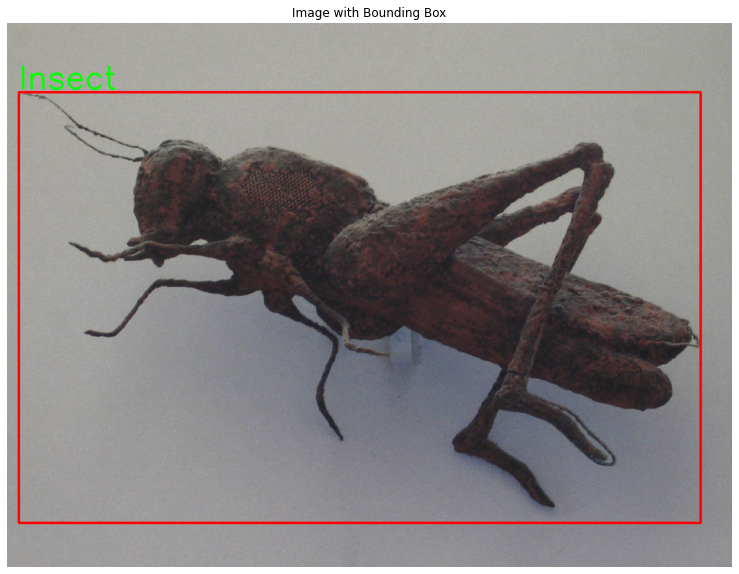

Image: (2592, 2361, 3)
Coordinates: (0, 0), (2187, 2590)


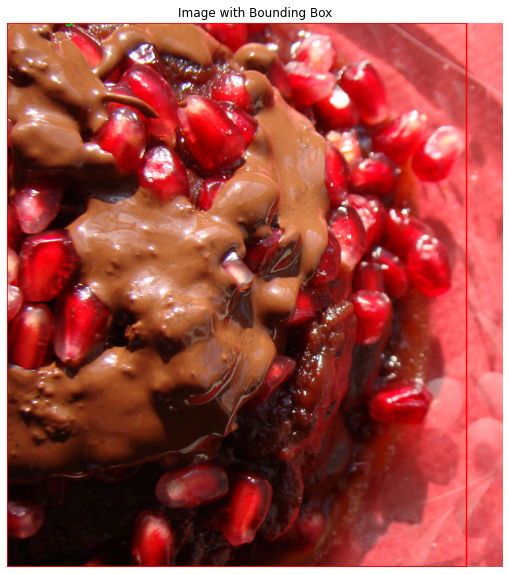

Image: (1427, 2140, 3)
Coordinates: (660, 140), (1895, 1234)


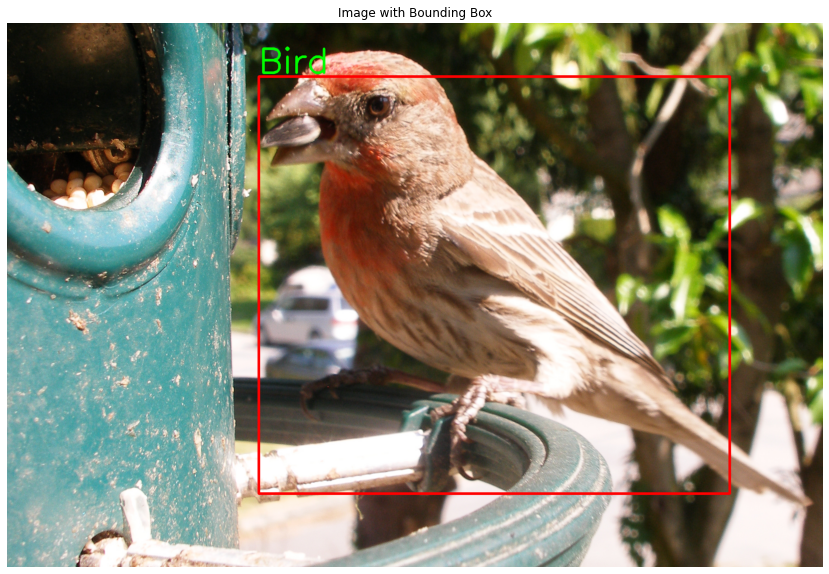

Image: (3456, 4608, 3)
Coordinates: (800, 1333), (3450, 2442)


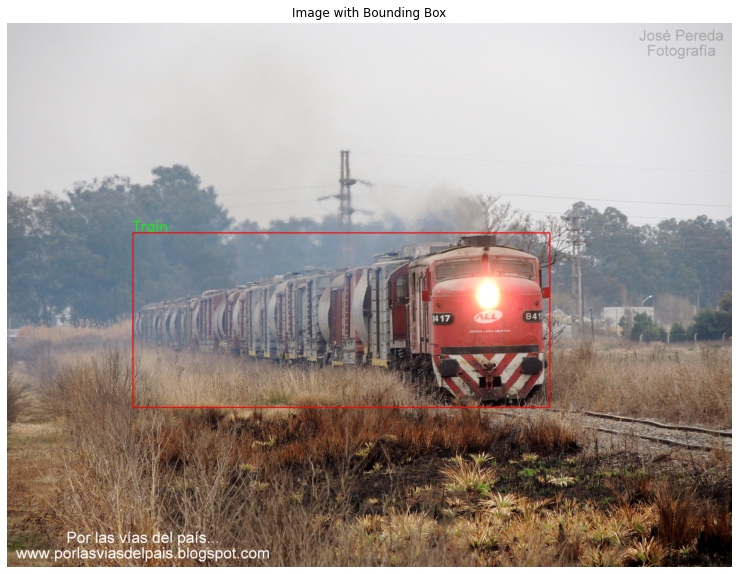

Image: (2048, 2048, 3)
Coordinates: (302, 451), (1568, 1561)


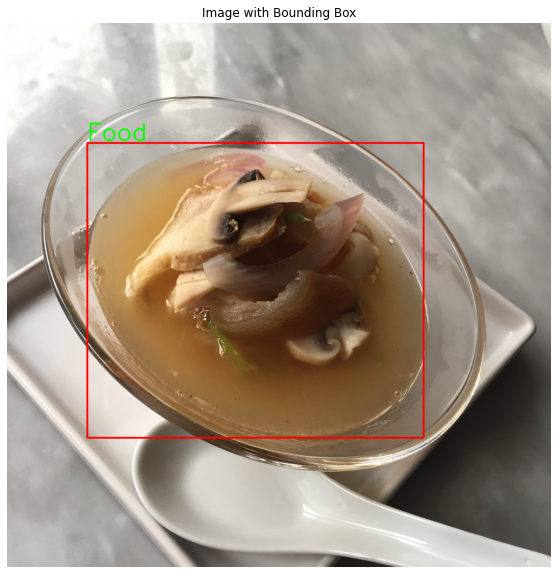

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

In [ ]:
class_descriptions[1].count() #this is shown that there are 601 classes , but we want to select some of them such as chair ,bed and table categories

601

In [ ]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

In [ ]:
bed_pd

0    1
257  /m/03ssj5  Bed

In [ ]:
#seperated labels
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

In [ ]:
#seperated bounding box's coordinates
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

ImageID     Source  ... IsDepiction  IsInside
5953      00041cc3701f7805     xclick  ...           0         0
5954      00041cc3701f7805     xclick  ...           0         0
9974      00074503ceae5131     xclick  ...           0         0
13671     000a54f1bdb96839     xclick  ...           0         0
17469     000da932ca7e68e4     xclick  ...           0         0
...                    ...        ...  ...         ...       ...
14585203  ff7f55b7f6794f63     xclick  ...           0         0
14595452  ffb716498f082103     xclick  ...           0         0
14600295  ffce182988b6b746     xclick  ...           0         0
14602507  ffd718211ba34626  activemil  ...           0         0
14602925  ffd95054b5fa8ba3     xclick  ...           0         0

[3563 rows x 13 columns]

In [ ]:
print('There are %d beds in the dataset' %(len(bed_bbox)))     #these are shown that how many bed,chair and table in dataset
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [ ]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

In [ ]:
# working on 10 images // only we take only 10 images of each class
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

In [ ]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

In [ ]:
print("Beds:",subbed_pd.shape, "Chair:", subchair_pd.shape, "Tables:", subtable_pd.shape)

Beds: (10, 12) Chair: (10, 12) Tables: (10, 12)


In [ ]:
subbed_pd.head()

ImageID  ... Rotation
736683   180eaae399121a8c  ...      NaN
1101169  c6f458d0e20b1eec  ...      NaN
1141009  faa7831b62dbe615  ...      0.0
1264335  87c06195b70fd243  ...      0.0
1417909  9ee9215dda95ab48  ...      0.0

[5 rows x 12 columns]

In [ ]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict() #index ve url bilgileri her bir sınıf için dictionary ile bir araya getirildi
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
mappings = [subbed_dict, subchair_dict, subtable_dict] #3 sınıf bir araya getirildi

In [ ]:
len(mappings)

3

In [ ]:
len(mappings[0])

10

In [ ]:
classes = ['Bed', 'Chair', 'Table']

In [ ]:
# download images in folders(Bed, Chair and table folder with 10 images each)


for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 3
Images Issues: 0
Images Issues: 1


In [ ]:
# save images to train and test directory, so create 2 folders
train_path = '/content/train'
test_path = '/content/test'

In [ ]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    

    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

# Yeni Bölüm

In [ ]:
train_img_count = os.listdir('/content/train')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  24


In [ ]:
test_img_count = os.listdir('/content/test')
print("Number of images in test found: ", len(test_img_count))

Number of images in test found:  27


In [ ]:
label_names = [label_name_bed, label_name_chair, label_name_table]  #details of data frame 

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  5cfdb9fdab7d3069.jpg  0.225586  0.395508  0.675516  0.898230     Table
1  5cfdb9fdab7d3069.jpg  0.575195  0.710938  0.710914  0.918879     Table
2  28237d5591345e3c.jpg  0.005625  0.620625  0.674167  0.999167     Table
3  28237d5591345e3c.jpg  0.221875  0.401250  0.485833  0.601667     Table
4  28237d5591345e3c.jpg  0.436250  0.638750  0.540833  0.725833     Table

In [ ]:
train_df.shape

(192, 6)

Image: (678, 1024, 3)
Coordinates: (231, 457), (405, 608)
Coordinates: (588, 481), (728, 622)
Coordinates: (94, 343), (266, 603)
Coordinates: (250, 356), (391, 582)
Coordinates: (476, 368), (648, 587)
Coordinates: (622, 348), (752, 581)
Coordinates: (739, 346), (890, 599)
Coordinates: (172, 539), (206, 576)
Coordinates: (229, 563), (264, 608)
Coordinates: (286, 552), (309, 589)
Coordinates: (321, 561), (366, 588)
Coordinates: (545, 548), (584, 576)
Coordinates: (600, 541), (636, 585)
Coordinates: (611, 520), (664, 548)
Coordinates: (686, 563), (721, 595)
Coordinates: (757, 568), (798, 602)
Coordinates: (821, 493), (869, 538)


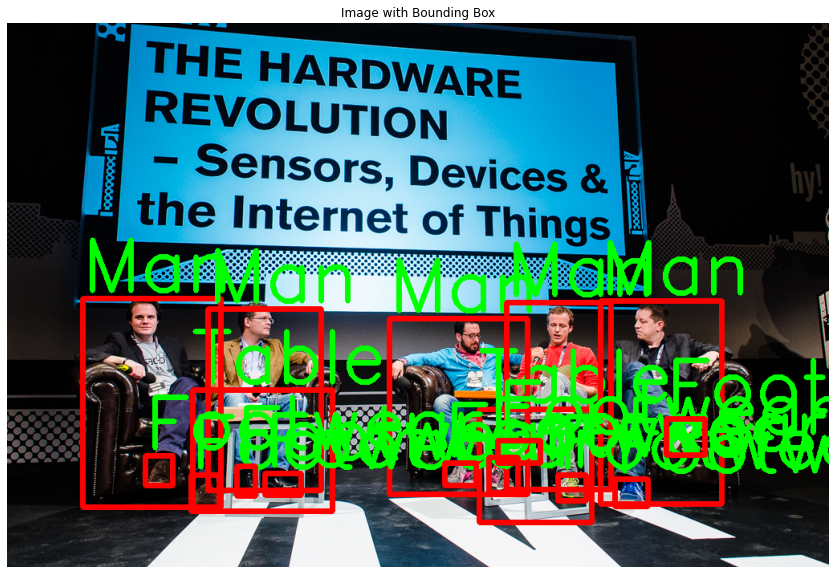

Image: (2448, 3264, 3)
Coordinates: (36, 928), (252, 1556)
Coordinates: (0, 0), (3261, 2445)
Coordinates: (18, 1650), (2025, 2445)
Coordinates: (724, 1189), (1309, 1472)
Coordinates: (1423, 1323), (2084, 1776)
Coordinates: (1856, 1232), (2178, 1527)
Coordinates: (3076, 1315), (3261, 1636)
Coordinates: (55, 1042), (316, 1619)


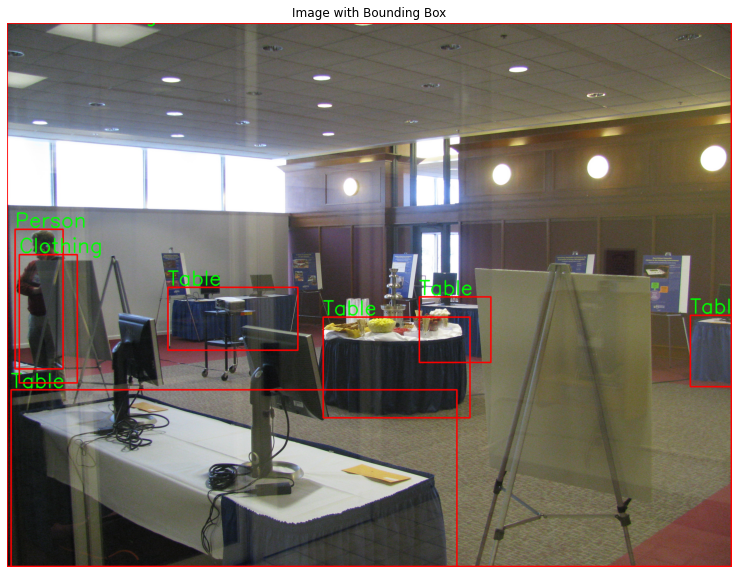

In [ ]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [ ]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])  

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [ ]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      train_file_path = '/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      test_file_path = '/test'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
